## E14 - 인물사진 만들기

하나의 카메라로 인물사진 만드는 방법   
촬영된 이미지에서 인물과 배경을 분리한 후 배경을 흐리게 만들어서 인물과 배경을 다시 합성한다.!

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib # 웹에서 데이터를 다운로드 받기 위한 모듈

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/0u.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(333, 500, 3)


#### 세그멘테이션

인물과 배경을 분리하기 위해 세그멘테이션을 사용한다.   
이미지 세그멘테이션: 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법   
모든 픽셀에 라벨을 할당하고 같은 라벨은 '공통적인 특징'을 가진다고 가정한다.  

시멘틱 세그멘테이션: 이미지에서 픽셀을 사람, 자동차, 비행기 등 물리적 단위로 분류하는 방법   
인스턴스 세그멘테이션: 시멘틱 세그멘테이션은 물체가 사람이라면 한덩어리로 묶어 버리지만 인스턴스 세그멘테이션은   
개개인 별로 다른 라벨을 가지게 한다.   

이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 경계를 나누는 것이다.   
참고하기: https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html

In [3]:
# DeepLab: 세그멘테이션 모델 중에서 성능이 좋아 많이 사용된다.
# https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# 사전에 학습된 모델 불러오기

# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

# 다운받은 deeplabv3_mnv2_pascal_train-aug_2018_01_29 모델은 pascal voc 2012라는 대형 데이터셋으로 학습된 v3버전

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
# 첫 단계: 준비된 이미지를 네트워크에 입력한다.

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max()) # seg_map.max(): pascal voc 라벨 수

(333, 500, 3) (341, 513, 3) 15


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

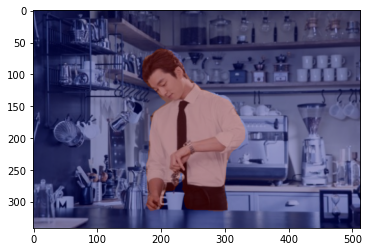

In [7]:
# person 라벨(15)만 추출하고 싶다.
# 15 외에는 0의 예측값을 가지게 만든다.

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

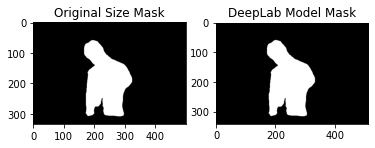

In [8]:
# 세그멘테이션 결과(mask)를 원래 이미지 크기로 복원하기
# 크기를 키울 때 보간(interpolation)을 고려해야 한다.
# 더 정확한 확대는 cv2.INTER_LINEAR 사용, cv.INTER_NEAREST보다
# 확실한 경계를 다시 정하기 위해 중간값인 128을 기준(임계값)으로 128이하으 값은 0으로 이상은 255로 만든다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

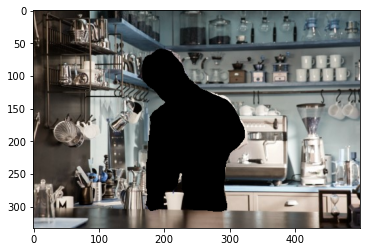

In [9]:
# 배경 흐리게 만들기
# bitwise_not(): 이미지가 반전된다.

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

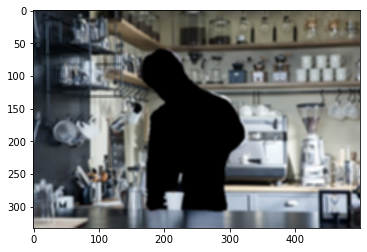

In [12]:
# 배경 이미지에 blur 처리하기

img_bg_blur = cv2.blur(img_bg, (5,5))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

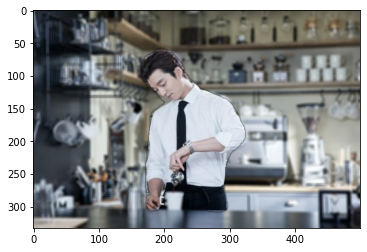

In [13]:
# 배경과 인물 이미지를 합성하기

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()